In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 220

In [2]:
df = pd.read_pickle('processedData.pkl')
ngcDatabase = pd.read_pickle('ngcDatabase.pkl')
dfUse = df[df['dso_list'].map(lambda x: len(x) > 0) & df['processes_used'].map(lambda x: len(x) > 1)]

In [3]:
def createGraph(data, ngc = None, objType = None, messier = None,count = 12):
    if messier:
        title = 'Relative postions of PixInsight Processes for M {}'.format(messier)
    elif ngc:
        title = 'Relative postions of PixInsight Processes for NGC {}'.format(ngc)
    elif objType:
        title = 'Relative postions of PixInsight Processes for {} Objects'.format(objType)
    else:
        title = 'Relative postions of PixInsight Processes'
    joyDF = pd.DataFrame(columns=['loc','proc'])
    for p in data['processes_used']:
        joyDF = joyDF.append(pd.DataFrame({'loc': np.linspace(0,1,len(p)), 'proc':p}))
    joyDF.reset_index(drop=True,inplace=True)
    
    # Initialize the FacetGrid object
    selection = joyDF['proc'].value_counts().head(count).index
    joyDFuse = joyDF[joyDF['proc'].map(lambda x: x in selection)]
    order = joyDFuse.groupby(by='proc').mean().sort_values('loc')
    pal = sns.cubehelix_palette(len(order), rot=-.25, light=.57)
    g = sns.FacetGrid(joyDFuse, row="proc", hue="proc", hue_order=order.index, aspect=15, size=.5, palette=pal,row_order=order.index)

    plt.xlim(-2.1,1.5)
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "loc", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, "loc", clip_on=False, color="w", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(.43+0.0 * order.index.get_loc(label), .2, label, fontweight="bold", color=color, 
                ha="right", va="center", transform=ax.transAxes)

    g.map(label, "loc")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set_xticklabels(['','','','','','Early','','','Late'])
    g.set_xlabels('')
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(title,fontweight="bold",color=pal[-1])
    g.despine(bottom=True, left=True)

In [4]:
def createGraphNGC(ngc,messier=None,count=12):
    data = dfUse[dfUse['dso_list'].map(lambda x: ngc in x)]
    objType = ''
    if len(data) < 5:
        objType = ngcDatabase.loc[ngc]['simpleType']
        print("There aren't very many examples for that object.")
        print("However, it is a {}, so we'll show you how those are usually processed.".format(objType))
        createGraphType(objType,count=count)
    elif messier:
        createGraph(data,messier=messier,count=count)
    else:
        createGraph(data,ngc=ngc,count=count)

In [5]:
def createGraphMessier(m,count=12):
    if m in ngcDatabase['Messier'].values:
        ngc = ngcDatabase[ngcDatabase['Messier'] == m].index[0]
        createGraphNGC(ngc,messier=m,count=count)
    else:
        print("Sorry, that's not an object we cataloged!")

In [6]:
def createGraphType(objType,count=12):
    data = dfUse[dfUse['has_' + objType]]
    createGraph(data,objType=objType,count=count)

In [7]:
def createGraphAll(count=12):
    createGraph(dfUse,count=count)

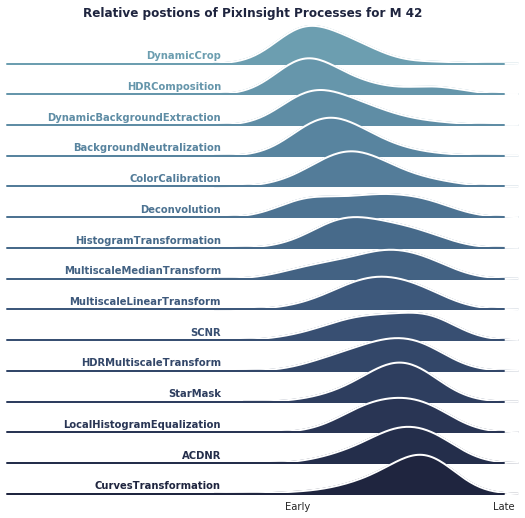

In [8]:
createGraphMessier(42,15)

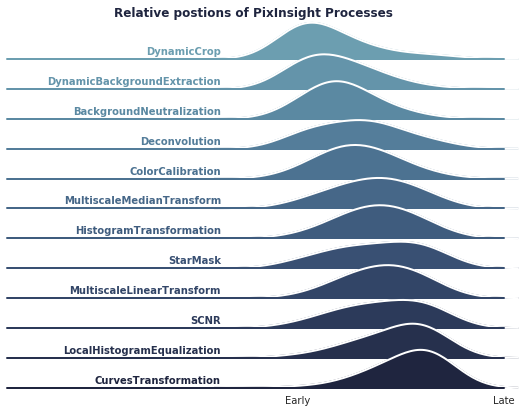

In [9]:
createGraphAll()

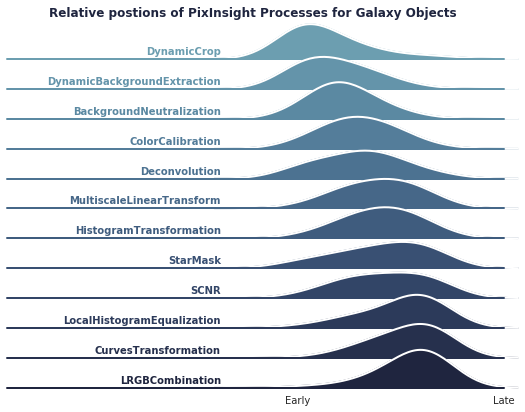

In [11]:
createGraphType("Galaxy")